In [25]:
import pandas as pd #trabalhar com dataframes
import numpy as np #calculos
import pickle #para ler objetos serializados
import matplotlib.pyplot as plt #para plotagem
import utils
import sys


In [26]:
filename = sys.argv[1] #FILEPATH como argumento

In [27]:
def read_and_normalize(file_path):
    '''
    Le um arquivo csv de entrada e retorna o dataframe normalizado 
    com os padroes definidos no treinamento
    '''
    #Vamos criar com uma quantidade menor de lag do treino
    #no treinamento adicionamos uma coluna a mais e consideramos a ultima coluna como y
    #nao sera o caso aqui por isso vamos criar com 1 lag a menos
    #para manter no formato
    #lag de treino = 15
    num_lag_treino = 14
    #Lendo o dadoa
    print("Lendo Arquivo...")
    df = pd.read_csv(file_path, header=None)
    #normalizando o dado
    print("Normalizando Dados...")
    df = utils.normalize_data(df)
    #criando Lag
    print("Criando 15 lags...")
    lagged_data = utils.create_lag(df, num_lag_treino,test=True)
    lagged_data = lagged_data.reset_index(drop=True)
    return lagged_data

def read_serialized_networks():
    '''
    Aqui fazemos a leitura das redes salvas na etapa de treinamento
    '''
    gating_network = pickle.load(open('redes_exportadas/rede_gating_pickle', 'rb'))
    print("Rede Gating carregada!")    
    all_experts = []
    num_experts_treino = 5
    for i in range(num_experts_treino):
        all_experts.append(pickle.load(open('redes_exportadas/rede_expert_pickle_{}'.format(i), 'rb')))
    
    print("{} experts carregados!".format(len(all_experts)))
    return gating_network,all_experts

In [28]:
def output_final(X, gating_network, all_experts):
    #Calcula saida do gating
    print("Calculando saidas da mistura...")
    gating_output = gating_network.feedforward(X)[-1]
    experts_outputs = []
    #calcula saida do experts
    for exp_net in all_experts:
        experts_outputs.append(exp_net.feedforward(X)[-1].tolist())
    #retorna o melhor expert como saida
    final_output = []
    for index_gate, result in enumerate(np.argmax(gating_output,axis=1)):
        final_output.append(experts_outputs[result][index_gate])
    return final_output

Rede Gating carregada!
5 experts carregados!


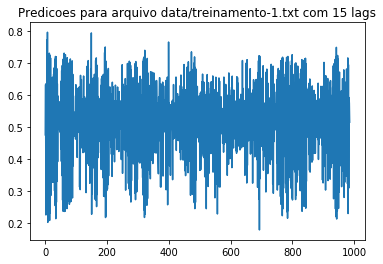

In [36]:
#le o dado
df = read_and_normalize(filename)
#carrega redes na memoria
gating_network,all_experts = read_serialized_networks()
#calcula saida
saida = np.ravel(output_final(df, gating_network, all_experts))
#salva saida como arquivo csv
print("Predicoes salvas em output_mistura.csv")
pd.DataFrame(saida).to_csv('output_mistura.csv', index=False)
#plota resultados
plt.plot(saida)
plt.title("Predicoes para arquivo {} com {} lags".format(filename,15))
plt.show()